In [325]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import os
from typing import Literal   

from statsmodels.tsa.api import VAR
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [326]:
import tf_keras as keras  
from tf_keras import layers
from tf_keras import Sequential
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tf_keras import Model
from tf_keras.losses import MeanSquaredError
from tf_keras.layers import LSTM, Dense, Input, Dropout
from tf_keras.optimizers import Adam
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.base import ForecastingHorizon
mse_loss = MeanSquaredError()

# TensorFlow Probability
tfd = tfp.distributions
tfpl = tfp.layers



In [ ]:
def load_de_eamd_qd(filepath: str = "./Data/EA-MD-QD-04-2025/DEdata.xlsx",
                    sheet: str | int | None = None) -> pd.DataFrame:
    """
    Liest die Excel‑Datei mit den EA‑MD/QD‑Daten ein.

    Parameter
    ----------
    filepath : str
        Pfad zur Excel‑Datei.
    sheet : str | int | None
        - None  ➜ alle Sheets werden eingelesen und als dict zurückgegeben
        - str   ➜ Name des gewünschten Sheets
        - int   ➜ Sheet‑Index (0‑basiert)

    Returns
    -------
    pd.DataFrame | dict[str, pd.DataFrame]
        DataFrame eines einzelnen Sheets oder Dict aller Sheets.
    """
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Datei nicht gefunden: {filepath}")
    
    print(f"Lade Datei: {filepath}")


    data = pd.read_excel(filepath, sheet_name=sheet, engine="openpyxl")

    if isinstance(data, pd.DataFrame):
        if "Time" in data.columns:
            data["Time"] = pd.to_datetime(data["Time"], errors='coerce')
            data.set_index("Time", inplace=True)

    print("Datei geladen")

    return data


In [ ]:
def apply_tcode(series: pd.Series, tcode: float) -> pd.Series:
    """Pure Stationierung ohne Resampling-Logik."""
    if tcode == 0:
        return series
    if tcode == 1:
        return 100 * np.log(series)
    if tcode in {2, 2.5}:
        return 100 * np.log(series).diff()
    if tcode == 3:
        return np.log(series).diff(2)
    if tcode == 4:
        return series.diff()
    if tcode == 5:
        return series.diff(2)
    if tcode == 4.5:
        return series.diff()
    raise ValueError(f"TCode {tcode} unbekannt")

def transform_panel(
    df_raw: pd.DataFrame,
    meta_df: pd.DataFrame,
    regime: Literal["TR", "TR1", "TR2"] = "TR1",
    monthly_to_quarterly: Literal["mean", "sum", "none"] = "mean",
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Gibt ZWEI DataFrames zurück:
      • df_q : Quartalsdaten (alle Reihen schon quartals‑taktend & stationär)
      • df_m : Monatsdaten (stationär; nur Monatsreihen)
    """
    if not isinstance(df_raw.index, (pd.DatetimeIndex, pd.PeriodIndex)):
        df_raw = df_raw.copy()
        df_raw.index = pd.to_datetime(df_raw.index)

    q_dict, m_dict = {}, {}

    for _, row in meta_df.iterrows():
        name  = row["Name"]
        if name not in df_raw.columns:
            continue

        tcode = row.get(regime, np.nan)

        freq = str(row["Frequency"]).upper()

        ser = df_raw[name]

        if freq.startswith("Q"):
            ser = ser.resample("Q").last()
            ser = apply_tcode(ser, tcode)
            q_dict[name] = ser

        elif freq.startswith("M"):
            ser = apply_tcode(ser, tcode)

            if monthly_to_quarterly != "none":
                if tcode in {2.5, 4.5}:    
                    ser = ser.resample("Q").mean()
                elif monthly_to_quarterly == "sum" and int(row["Aggregation"]) == 1:
                    ser = ser.resample("Q").sum()
                elif monthly_to_quarterly == "mean":
                    ser = ser.resample("Q").mean()

            m_dict[name] = ser if monthly_to_quarterly == "none" else apply_tcode(df_raw[name], tcode)
            q_dict[name] = ser

    df_q = pd.concat(q_dict, axis=1).dropna(how="all")
    df_m = pd.concat(m_dict, axis=1).dropna(how="all") if m_dict else pd.DataFrame()

    return df_q, df_m

### Lade EU Weite Daten

In [233]:
df_EU = load_de_eamd_qd(filepath="./Data/EA-MD-QD-04-2025/EAdata.xlsx", sheet="data")
meta_df_EU = load_de_eamd_qd(filepath="./Data/EA-MD-QD-04-2025/EAdata.xlsx", sheet="info")

Lade Datei: ./Data/EA-MD-QD-04-2025/EAdata.xlsx
Datei geladen
Lade Datei: ./Data/EA-MD-QD-04-2025/EAdata.xlsx
Datei geladen


In [234]:
df_q_EU, df_m_EU = transform_panel(df_EU, meta_df_EU)

/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_41382/2036466473.py:52: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  ser = ser.resample("Q").last()
/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_41382/2036466473.py:52: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  ser = ser.resample("Q").last()
/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_41382/2036466473.py:63: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  ser = ser.resample("Q").mean()
/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_41382/2036466473.py:67: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  ser = ser.resample("Q").mean()


In [235]:
df_q_EU.rename(columns={"GDP_EA": "GDP", "UNETOT_EA": "UNETOT",
                                  "HICPNEF_EA": "HICPNEF",
                                  "EMP_EA": "EMP", "LTIRT_EACC": "LTIRT",
                                  "SHIX_EA": "SHIX"}, inplace=True)

df_m_EU.rename(columns={"GDP_EA": "GDP", "UNETOT_EA": "UNETOT",
                                   "HICPNEF_EA": "HICPNEF",
                                  "EMP_EA": "EMP", "LTIRT_EACC": "LTIRT",
                                  "SHIX_EA": "SHIX"}, inplace=True)

In [236]:
cols_to_standardize = ["GDP", "UNETOT",  "HICPNEF", "IRT3M_EACC", "EMP", "LTIRT", "SHIX", "M2_EACC"]

In [237]:
## werden benötigt um die bei den anderen ds anzuhängen  
columns_to_add = ['IRT3M_EACC', 'M2_EACC']
Euro_Area_data_q = df_q_EU[columns_to_add]
Euro_Area_data_m = df_m_EU[columns_to_add]

In [238]:
df_q_EU[cols_to_standardize] = scaler.fit_transform(df_q_EU[cols_to_standardize])                                       

### Lade Deutschen Datensatz

In [125]:
df_DE = load_de_eamd_qd(filepath="./Data/EA-MD-QD-04-2025/DEdata.xlsx", sheet="data")
meta_df_DE = load_de_eamd_qd(filepath="./Data/EA-MD-QD-04-2025/DEdata.xlsx", sheet="info")

Lade Datei: ./Data/EA-MD-QD-04-2025/DEdata.xlsx
Datei geladen
Lade Datei: ./Data/EA-MD-QD-04-2025/DEdata.xlsx
Datei geladen


In [126]:
df_q_DE, df_m_DE = transform_panel(df_DE, meta_df_DE)

/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_41382/2036466473.py:52: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  ser = ser.resample("Q").last()
/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_41382/2036466473.py:52: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  ser = ser.resample("Q").last()
/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_41382/2036466473.py:63: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  ser = ser.resample("Q").mean()
/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_41382/2036466473.py:67: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  ser = ser.resample("Q").mean()


In [127]:
df_q_DE.rename(columns={"GDP_DE": "GDP", "UNETOT_DE": "UNETOT",
                                  "HICPNEF_DE": "HICPNEF",
                                  "EMP_DE": "EMP", "LTIRT_DE": "LTIRT",
                                  "SHIX_DE": "SHIX"}, inplace=True)

df_q_DE.rename(columns={"GDP_DE": "GDP", "UNETOT_DE": "UNETOT",
                                   "HICPNEF_DE": "HICPNEF",
                                  "EMP_DE": "EMP", "LTIRT_DE": "LTIRT",
                                  "SHIX_DE": "SHIX"}, inplace=True)

In [128]:
df_q_DE = df_q_DE.join(Euro_Area_data_q, how='left')  
df_m_DE = df_m_DE.join(Euro_Area_data_m, how='left')
df_q_DE[cols_to_standardize] = scaler.fit_transform(df_q_DE[cols_to_standardize])                                       

In [75]:
df_q_DE[cols_to_standardize]

,GDP,UNETOT,HICPNEF,IRT3M_EACC,EMP,LTIRT,SHIX,M2_EACC
Time,,,,,,,,
2000-03-31,NaN,-0.050000,-0.238774,0.403900,NaN,-0.210000,7.361947,0.335308
2000-06-30,0.770210,-0.033333,-0.046340,0.526633,0.353657,-0.090000,-3.310582,0.175773
2000-09-30,0.060880,-0.033333,0.271414,0.255400,0.125012,-0.033333,-1.202225,0.326457
2000-12-31,-0.426908,-0.066667,0.059150,0.133767,-0.016659,-0.143333,-4.204748,0.115508
2001-03-31,2.131516,-0.033333,0.251987,-0.188933,-0.286418,-0.196667,-2.845396,1.206819
...,...,...,...,...,...,...,...,...
2024-03-31,0.236300,0.033333,0.398989,-0.019700,0.134868,-0.006667,2.038968,0.074164
2024-06-30,-0.296065,0.066667,0.185657,-0.102467,0.077999,0.106667,-0.166499,0.339924
2024-09-30,0.105146,0.000000,0.229733,-0.185633,-0.059084,-0.206667,0.734315,0.240754


### Lade französischen Datensatz

In [60]:
df_FR = load_de_eamd_qd(filepath="./Data/EA-MD-QD-04-2025/FRdata.xlsx", sheet="data")
meta_df_FR = load_de_eamd_qd(filepath="./Data/EA-MD-QD-04-2025/FRdata.xlsx", sheet="info")

Lade Datei: ./Data/EA-MD-QD-04-2025/FRdata.xlsx
Datei geladen
Lade Datei: ./Data/EA-MD-QD-04-2025/FRdata.xlsx
Datei geladen


In [61]:
df_q_FR, df_m_FR = transform_panel(df_FR, meta_df_FR)

/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_41382/2036466473.py:52: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  ser = ser.resample("Q").last()
/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_41382/2036466473.py:52: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  ser = ser.resample("Q").last()
/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_41382/2036466473.py:63: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  ser = ser.resample("Q").mean()
/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_41382/2036466473.py:67: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  ser = ser.resample("Q").mean()


In [63]:
df_q_FR.rename(columns={"GDP_FR": "GDP", "UNETOT_FR": "UNETOT",
                                  "HICPNEF_FR": "HICPNEF",
                                  "EMP_FR": "EMP", "LTIRT_FR": "LTIRT",
                                  "SHIX_FR": "SHIX"}, inplace=True)

df_q_FR.rename(columns={"GDP_FR": "GDP", "UNETOT_FR": "UNETOT",
                                   "HICPNEF_FR": "HICPNEF",
                                  "EMP_FR": "EMP", "LTIRT_FR": "LTIRT",
                                  "SHIX_FR": "SHIX"}, inplace=True)

In [129]:
df_q_FR = df_q_FR.join(Euro_Area_data_q, how='left')  
df_m_FR = df_m_FR.join(Euro_Area_data_m, how='left')
df_q_FR[cols_to_standardize] = scaler.fit_transform(df_q_FR[cols_to_standardize])    

### Lade Italenischen Datensatz

In [65]:
df_IT = load_de_eamd_qd(filepath="./Data/EA-MD-QD-04-2025/ITdata.xlsx", sheet="data")
meta_df_IT = load_de_eamd_qd(filepath="./Data/EA-MD-QD-04-2025/ITdata.xlsx", sheet="info")

Lade Datei: ./Data/EA-MD-QD-04-2025/ITdata.xlsx
Datei geladen
Lade Datei: ./Data/EA-MD-QD-04-2025/ITdata.xlsx
Datei geladen


In [66]:
df_q_IT, df_m_IT = transform_panel(df_IT, meta_df_IT)

/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_41382/2036466473.py:52: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  ser = ser.resample("Q").last()
/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_41382/2036466473.py:52: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  ser = ser.resample("Q").last()
/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_41382/2036466473.py:63: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  ser = ser.resample("Q").mean()
/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_41382/2036466473.py:67: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  ser = ser.resample("Q").mean()


In [67]:
df_q_IT.rename(columns={"GDP_IT": "GDP", "UNETOT_IT": "UNETOT",
                                  "HICPNEF_IT": "HICPNEF",
                                  "EMP_IT": "EMP", "LTIRT_IT": "LTIRT",
                                  "SHIX_IT": "SHIX"}, inplace=True)

df_q_IT.rename(columns={"GDP_IT": "GDP", "UNETOT_IT": "UNETOT",
                                   "HICPNEF_IT": "HICPNEF",
                                  "EMP_IT": "EMP", "LTIRT_IT": "LTIRT",
                                  "SHIX_IT": "SHIX"}, inplace=True)

In [130]:
df_q_IT = df_q_IT.join(Euro_Area_data_q, how='left')  
df_m_IT = df_m_IT.join(Euro_Area_data_m, how='left')
df_q_IT[cols_to_standardize] = scaler.fit_transform(df_q_IT[cols_to_standardize])    

### Inspect and plot the Data

In [131]:
## Wichtge Wirtschaftskrisen 
krisen = [
    ("2001-03-01", "2001-11-01"),  # Dotcom-Blase
    ("2007-12-01", "2009-06-01"),  # Finanzkrise
    ("2020-02-01", "2021-12-01")   # COVID-19-Pandemie
]

# Datumskonvertierung
krisen = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in krisen]

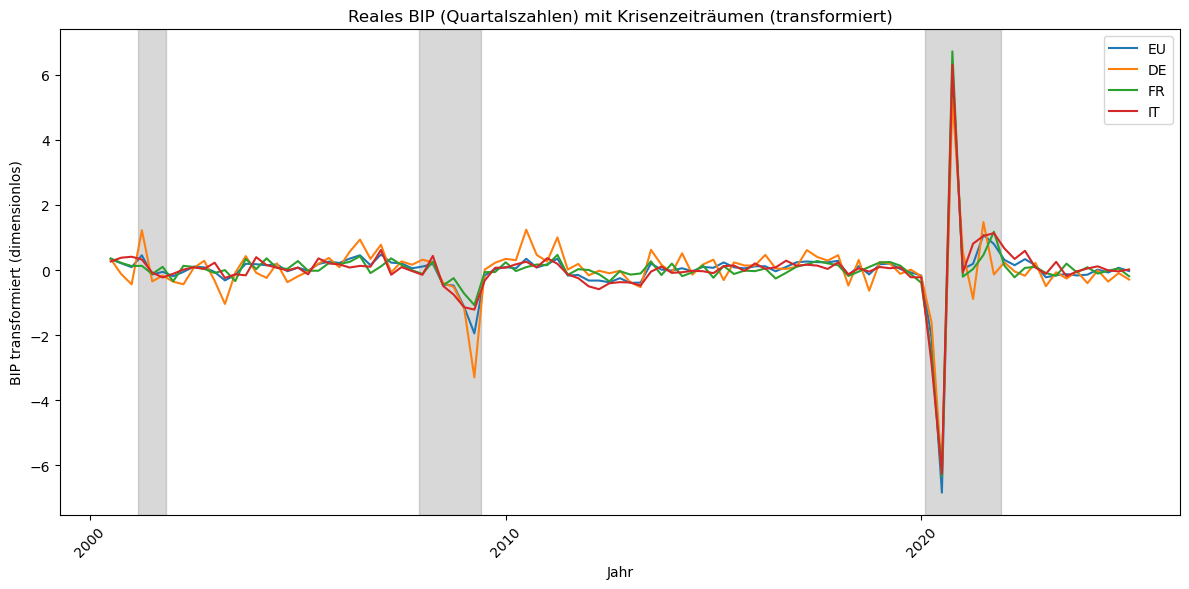

In [135]:
plt.figure(figsize=(12, 6))
plt.plot(df_q_EU.index, df_q_EU['GDP'], label='EU')
plt.plot(df_q_DE.index, df_q_DE['GDP'], label='DE')
plt.plot(df_q_FR.index, df_q_FR['GDP'], label='FR')
plt.plot(df_q_IT.index, df_q_IT['GDP'], label='IT')
plt.xlabel('Jahr')
plt.ylabel('BIP transformiert (dimensionlos)')
plt.title('Reales BIP (Quartalszahlen) mit Krisenzeiträumen (transformiert)')
plt.legend()

# Graue Schattierung für Krisenzeiträume
ax = plt.gca()
for start, end in krisen:
    ax.axvspan(start, end, color='gray', alpha=0.3)

# Achsenformatierung: nur alle 10 Jahre anzeigen
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("./plots/BIP_Euro_Area.png")
plt.show()

### Prognose mit VAR

In [372]:
def Var_Forecast(data, initial_window=54, forecast_steps=1):
    y_preds = []
    y_trues = []
    y_conf_int = []
    for i in range(initial_window, len(data) - forecast_steps):
        train = data.iloc[:i]
        test = data.iloc[i:i + forecast_steps]

        # Fit VAR model
        model = VAR(train)
        try:
            results = model.fit(maxlags=5, ic='aic')
        except Exception as e:
            print(f"Skipping step {i} due to model error: {e}")
            continue

        # Forecast
        #y_forecast = results.forecast(train.values[-results.k_ar:], steps=forecast_steps)
        y_forecast, stderr, conf_int = results.forecast_interval(train.values[-results.k_ar:], steps=forecast_steps)


        # Save only GDPC1
        y_preds.append(y_forecast[0][0])           # First row, first column
        y_trues.append(test.iloc[0, 0])            # First row, first column in true data
        y_conf_int.append(conf_int[0,0])             # First row, confidence interval
    return y_preds, y_trues, y_conf_int


In [373]:
data = df_q_EU[cols_to_standardize].dropna()
data.head()

,GDP,UNETOT,HICPNEF,IRT3M_EACC,EMP,LTIRT,SHIX,M2_EACC
Time,,,,,,,,
2000-06-30,0.335349,-0.679036,-0.620372,2.073704,0.889699,-0.262306,-0.440226,-0.969474
2000-09-30,0.206795,-0.679036,-0.370143,1.013023,0.603050,0.023417,-0.197286,-0.419747
2000-12-31,0.087571,-0.679036,-0.502314,0.537365,0.518907,-0.579777,-0.877861,-1.189333
2001-03-31,0.451696,-0.679036,-0.299322,-0.724581,0.105735,-0.770259,-1.267363,2.791988
2001-06-30,-0.138423,0.137424,0.417248,-0.473391,-0.124712,0.991703,0.112908,0.730445


In [374]:
data.index.freq = pd.infer_freq(data.index)
# Expanding window forecast
y_preds, y_trues, y_conf_int = Var_Forecast(data, initial_window=54, forecast_steps=1)

rmse = np.sqrt(mean_squared_error(y_preds, y_trues))
print(f"RMSE: {rmse:.3f}")

RMSE: 3.692


In [379]:
y_preds = np.array(y_preds)
y_conf_int = np.array(y_conf_int)
results_df = pd.DataFrame({
    "date": data.index[-len(y_trues):],
    "true": y_trues,
    "pred_mean": y_preds,
    "CI_lower": y_preds-y_conf_int,
    "CI_upper": y_preds+y_conf_int,
})
results_df.to_csv("./Data/results/VAR_EU_results.csv", index=False)

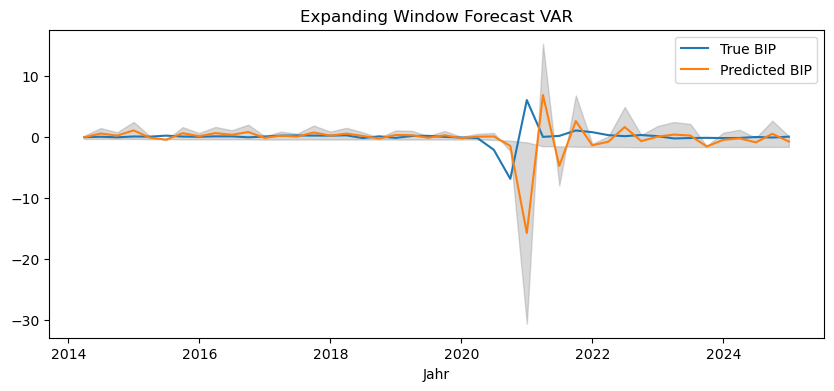

RMSE: 3.692


In [375]:
# Auswertung
dates = data.index[-len(y_preds):]  # Get the corresponding dates for the predictions
plt.figure(figsize=(10, 4))
plt.plot(dates, y_trues, label='True BIP')
plt.plot(dates, y_preds, label='Predicted BIP')
plt.xlabel("Jahr")
plt.legend()
# Konfidenzintervalle als graue Schattierung hinzufügen
y_preds_arr = np.array(y_preds)
y_conf_arr = np.array(y_conf_int)
plt.fill_between(dates, (y_preds_arr + y_conf_arr), (y_preds_arr - y_conf_arr)  , color='gray', alpha=0.3, label='Konfidenzintervall')
plt.title("Expanding Window Forecast VAR")
#plt.savefig("./plots/final_forecast_VAR_CI.png")
plt.show()

rmse = np.sqrt(mean_squared_error(y_preds, y_trues))
print(f"RMSE: {rmse:.3f}")

Auswertung Deutschland

In [380]:
data = df_q_DE[cols_to_standardize].dropna()
data.index.freq = pd.infer_freq(data.index)
# Expanding window forecast
y_preds, y_trues, y_conf_int = Var_Forecast(data, initial_window=54, forecast_steps=1)

rmse = np.sqrt(mean_squared_error(y_preds, y_trues))
print(f"RMSE: {rmse:.3f}")


RMSE: 1.835


In [381]:
y_preds = np.array(y_preds)
y_conf_int = np.array(y_conf_int)
results_df = pd.DataFrame({
    "date": data.index[-len(y_trues):],
    "true": y_trues,
    "pred_mean": y_preds,
    "CI_lower": y_preds-y_conf_int,
    "CI_upper": y_preds+y_conf_int,
})
results_df.to_csv("./Data/results/VAR_DE_results.csv", index=False)

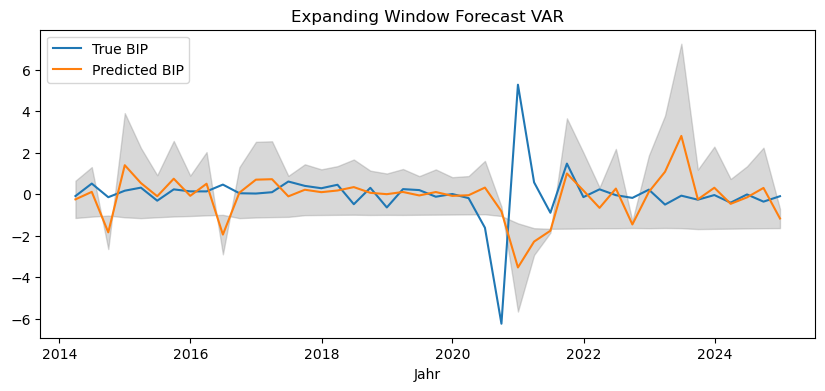

RMSE: 1.835


In [165]:
# Auswertung
dates = data.index[-len(y_preds):]  # Get the corresponding dates for the predictions
plt.figure(figsize=(10, 4))
plt.plot(dates, y_trues, label='True BIP')
plt.plot(dates, y_preds, label='Predicted BIP')
plt.xlabel("Jahr")
plt.legend()
# Konfidenzintervalle als graue Schattierung hinzufügen
y_preds_arr = np.array(y_preds)
y_conf_arr = np.array(y_conf_int)
plt.fill_between(dates, (y_preds_arr + y_conf_arr), (y_preds_arr - y_conf_arr)  , color='gray', alpha=0.3, label='Konfidenzintervall')
plt.title("Expanding Window Forecast VAR")
#plt.savefig("./plots/final_forecast_VAR_CI.png")
plt.show()

rmse = np.sqrt(mean_squared_error(y_preds, y_trues))
print(f"RMSE: {rmse:.3f}")

Auswertung Frankreich

In [382]:
data = df_q_FR[cols_to_standardize].dropna()
data.index.freq = pd.infer_freq(data.index)
# Expanding window forecast
y_preds, y_trues, y_conf_int = Var_Forecast(data, initial_window=54, forecast_steps=1)

rmse = np.sqrt(mean_squared_error(y_preds, y_trues))
print(f"RMSE: {rmse:.3f}")


RMSE: 3.157


In [383]:
y_preds = np.array(y_preds)
y_conf_int = np.array(y_conf_int)
results_df = pd.DataFrame({
    "date": data.index[-len(y_trues):],
    "true": y_trues,
    "pred_mean": y_preds,
    "CI_lower": y_preds-y_conf_int,
    "CI_upper": y_preds+y_conf_int,
})
results_df.to_csv("./Data/results/VAR_FR_results.csv", index=False)

Auswertung Italien

In [384]:
data = df_q_IT[cols_to_standardize].dropna()
data.index.freq = pd.infer_freq(data.index)
# Expanding window forecast
y_preds, y_trues, y_conf_int = Var_Forecast(data, initial_window=54, forecast_steps=1)

rmse = np.sqrt(mean_squared_error(y_preds, y_trues))
print(f"RMSE: {rmse:.3f}")


RMSE: 3.189


In [385]:
y_preds = np.array(y_preds)
y_conf_int = np.array(y_conf_int)
results_df = pd.DataFrame({
    "date": data.index[-len(y_trues):],
    "true": y_trues,
    "pred_mean": y_preds,
    "CI_lower": y_preds-y_conf_int,
    "CI_upper": y_preds+y_conf_int,
})
results_df.to_csv("./Data/results/VAR_IT_results.csv", index=False)

### Auswertung mit BNN

In [292]:

def evaluate_BNN_epistemic(data_scaled, window_length=5, hidden_layer_sizes=32, initial_window=54, n_samples=100):
    n_total = len(data_scaled)

    y_preds_mean = []
    y_preds_lower = []
    y_preds_upper = []
    y_trues = []

    for i in range(initial_window, n_total - 1):
        train_data = data_scaled[:i]

        # Sequences erstellen
        X_train, y_train = [], []
        for j in range(window_length, len(train_data)):
            X_train.append(train_data[j - window_length:j])
            y_train.append(train_data[j, 0])  # Ziel: GDPC1

        X_train = np.array(X_train)
        y_train = np.array(y_train)

        # BNN-Modell (nur epistemische Unsicherheit)
        model = keras.Sequential([
            keras.Input(shape=(window_length, data_scaled.shape[1])),
            layers.Flatten(),
            tfpl.DenseFlipout(hidden_layer_sizes, activation='relu'),
            tfpl.DenseFlipout(1)
        ])

    

        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, verbose=0)

        # Vorhersage mit n_samples für epistemische Unsicherheit
        x_input = data_scaled[i - window_length:i].reshape(1, window_length, data_scaled.shape[1])
        preds = np.array([model(x_input, training=True).numpy().flatten()[0] for _ in range(n_samples)])

        pred_mean = np.mean(preds)
        ci_lower = np.percentile(preds, 2.5)
        ci_upper = np.percentile(preds, 97.5)

        y_preds_mean.append(pred_mean)
        y_preds_lower.append(ci_lower)
        y_preds_upper.append(ci_upper)

        y_true = data_scaled[i, 0]
        y_trues.append(y_true)

    rmse = np.sqrt(mean_squared_error(y_trues, y_preds_mean))

    return rmse, y_preds_mean, y_preds_lower, y_preds_upper, y_trues


Für die EU

In [293]:
data = df_q_EU[cols_to_standardize].dropna()
data.index.freq = pd.infer_freq(data.index)
# Expanding window forecast
rmse, y_preds_mean, y_preds_lower, y_preds_upper, y_trues = evaluate_BNN_epistemic(data.values, window_length=5, hidden_layer_sizes=32, initial_window=54, n_samples=100)

print(f"RMSE: {rmse:.3f}")


/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variabl

RMSE: 1.440


In [295]:
print(f"RMSE: {rmse:.3f}")
results_df = pd.DataFrame({
    "date": data.index[-len(y_trues):],
    "true": y_trues,
    "pred_mean": y_preds_mean,
    "CI_lower": y_preds_lower,
    "CI_upper": y_preds_upper,
})
results_df.to_csv("./Data/results/BNN_EU_results.csv", index=False)

RMSE: 1.440


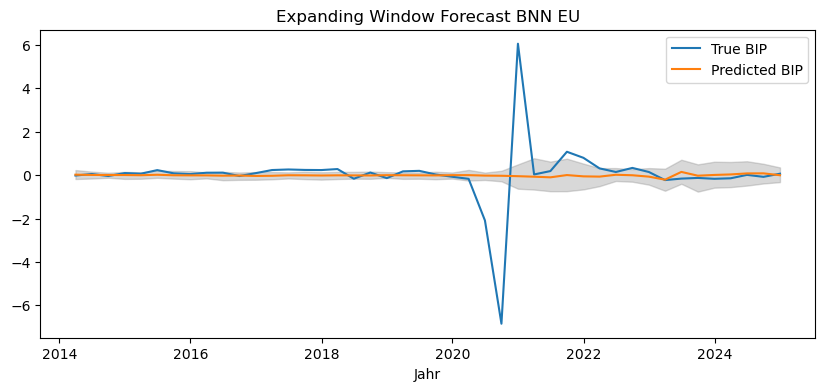

RMSE: 1.440


In [296]:
# Auswertung
dates = data.index[-len(y_trues):]  # Get the corresponding dates for the predictions
plt.figure(figsize=(10, 4))
plt.plot(dates, y_trues, label='True BIP')
plt.plot(dates, y_preds_mean, label='Predicted BIP')
plt.xlabel("Jahr")
plt.legend()
# Konfidenzintervale als graue Schattierung hinzufügen
plt.fill_between(dates, y_preds_upper, y_preds_lower, color='gray', alpha=0.3, label='Konfidenzintervall')
plt.title("Expanding Window Forecast BNN EU")
#plt.savefig("./plots/final_forecast_VAR_CI.png")
plt.show()

print(f"RMSE: {rmse:.3f}")

Für Detuschland 

In [297]:
data = df_q_DE[cols_to_standardize].dropna()
data.index.freq = pd.infer_freq(data.index)
# Expanding window forecast
rmse, y_preds_mean, y_preds_lower, y_preds_upper, y_trues = evaluate_BNN_epistemic(data.values, window_length=5, hidden_layer_sizes=32, initial_window=54, n_samples=100)

print(f"RMSE: {rmse:.3f}")


/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variabl

RMSE: 1.320


In [298]:
print(f"RMSE: {rmse:.3f}")
results_df = pd.DataFrame({
    "date": data.index[-len(y_trues):],
    "true": y_trues,
    "pred_mean": y_preds_mean,
    "CI_lower": y_preds_lower,
    "CI_upper": y_preds_upper,
})
results_df.to_csv("./Data/results/BNN_DE_results.csv", index=False)

RMSE: 1.320


Für Frankreich

In [299]:
data = df_q_FR[cols_to_standardize].dropna()
data.index.freq = pd.infer_freq(data.index)
# Expanding window forecast
rmse, y_preds_mean, y_preds_lower, y_preds_upper, y_trues = evaluate_BNN_epistemic(data.values, window_length=5, hidden_layer_sizes=32, initial_window=54, n_samples=100)

print(f"RMSE: {rmse:.3f}")


/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variabl

RMSE: 1.473


In [300]:
print(f"RMSE: {rmse:.3f}")
results_df = pd.DataFrame({
    "date": data.index[-len(y_trues):],
    "true": y_trues,
    "pred_mean": y_preds_mean,
    "CI_lower": y_preds_lower,
    "CI_upper": y_preds_upper,
})
results_df.to_csv("./Data/results/BNN_FR_results.csv", index=False)

RMSE: 1.473


Für Italien

In [301]:
data = df_q_IT[cols_to_standardize].dropna()
data.index.freq = pd.infer_freq(data.index)
# Expanding window forecast
rmse, y_preds_mean, y_preds_lower, y_preds_upper, y_trues = evaluate_BNN_epistemic(data.values, window_length=5, hidden_layer_sizes=32, initial_window=54, n_samples=100)

print(f"RMSE: {rmse:.3f}")


/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variabl

RMSE: 1.454


In [302]:
print(f"RMSE: {rmse:.3f}")
results_df = pd.DataFrame({
    "date": data.index[-len(y_trues):],
    "true": y_trues,
    "pred_mean": y_preds_mean,
    "CI_lower": y_preds_lower,
    "CI_upper": y_preds_upper,
})
results_df.to_csv("./Data/results/BNN_IT_results.csv", index=False)

RMSE: 1.454


### Nutze Pretraining um Ergebnisse zu verbessern

In [303]:
from Forcasting_lib import load_fred_data, make_stationary, standardize_data
## load and transform data
df, transform_codes = load_fred_data()
df_stationary = make_stationary(df, transform_codes)

cols_to_standardize = [
    'GDPC1',      # Reales BIP
    'UNRATE',     # Arbeitslosenquote
    'FEDFUNDS',   # Federal Funds Rate
    'CPILFESL',   # Verbraucherpreisindex ohne Energie und Nahrungsmittel  #fehlt ein Wert 
    'PAYEMS',     # Beschäftigte außerhalb der Landwirtschaft
    'GS10',       # Rendite 10-jähriger Staatsanleihen
    'M2REAL',     # Reale Geldmenge M2
    'S&P 500'       # S&P 500 Index
]


df_std, scaler = standardize_data(df_stationary, cols_to_standardize)
data_us = df_std[cols_to_standardize].dropna()

Datei 'current.csv' gefunden. Lade lokal...
Daten erfolgreich vorbereitet.
Standardisierung abgeschlossen.


In [304]:
def make_sequences(data, window_length, target_col=0):
    """Erzeugt (X, y) mit 3D-Input: (samples, window_length, n_features)."""
    X, y = [], []
    for t in range(window_length, len(data)):
        X.append(data[t-window_length:t, :])
        y.append(data[t, target_col])
    return np.array(X), np.array(y)


### Use only data up to 2010 to avoid data leakage 
X_us, Y_us = make_sequences(data_us.values[:201], window_length=5, target_col=0)

In [269]:
def build_bnn(window_length = 5, n_features=8, hidden=32, learning_rate=1e-3, kl_weight=None):
    model = keras.Sequential([
        keras.Input(shape=(window_length, n_features)),
        layers.Flatten(),
        tfpl.DenseFlipout(hidden, activation='relu'),
        tfpl.DenseFlipout(1)
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='mse')
    return model

bnn_us = build_bnn()
bnn_us.fit(X_us, Y_us, epochs=100, batch_size=16, validation_split=0.1, callbacks=[keras.callbacks.EarlyStopping(
               patience=10, restore_best_weights=True)], verbose=0)


/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variabl

In [305]:
bnn_eu = build_bnn()
bnn_eu.set_weights(bnn_us.get_weights())   # Mittel & Log-Var der Flipout-Layer werden mitkopiert

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variabl

In [307]:
cols_to_standardize = ["GDP", "UNETOT",  "HICPNEF", "IRT3M_EACC", "EMP", "LTIRT", "SHIX", "M2_EACC"]

In [308]:
data = df_q_EU[cols_to_standardize].dropna()

In [309]:
def evaluate_BNN_pretrained(data_scaled, bnn_us,  initial_window=54, n_samples=100, learning_rate=1e-3):
    n_total = len(data_scaled)
    window_length = 5

    y_preds_mean = []
    y_preds_lower = []
    y_preds_upper = []
    y_trues = []

    for i in range(initial_window, n_total - 1):
        train_data = data_scaled[:i]

        # Sequences erstellen
        X_train, y_train = [], []
        for j in range(window_length, len(train_data)):
            X_train.append(train_data[j - window_length:j])
            y_train.append(train_data[j, 0])  # Ziel: GDPC1

        X_train = np.array(X_train)
        y_train = np.array(y_train)

        # BNN-Modell (nur epistemische Unsicherheit)
        model =  build_bnn()
        model.set_weights(bnn_us.get_weights())


        model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='mse')
        model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, verbose=0)

        # Vorhersage mit n_samples für epistemische Unsicherheit
        x_input = data_scaled[i - window_length:i].reshape(1, window_length, data_scaled.shape[1])
        preds = np.array([model(x_input, training=True).numpy().flatten()[0] for _ in range(n_samples)])

        pred_mean = np.mean(preds)
        ci_lower = np.percentile(preds, 2.5)
        ci_upper = np.percentile(preds, 97.5)

        y_preds_mean.append(pred_mean)
        y_preds_lower.append(ci_lower)
        y_preds_upper.append(ci_upper)

        y_true = data_scaled[i, 0]
        y_trues.append(y_true)

    rmse = np.sqrt(mean_squared_error(y_trues, y_preds_mean))

    return rmse, y_preds_mean, y_preds_lower, y_preds_upper, y_trues


In [310]:
rmse, y_preds_mean, y_preds_lower, y_preds_upper, y_trues = evaluate_BNN_pretrained(data.values, bnn_us, initial_window=54, n_samples=100, learning_rate=1e-3)
print(rmse)

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variabl

1.5276438485604509


In [311]:
print(f"RMSE: {rmse:.3f}")
results_df = pd.DataFrame({
    "date": data.index[-len(y_trues):],
    "true": y_trues,
    "pred_mean": y_preds_mean,
    "CI_lower": y_preds_lower,
    "CI_upper": y_preds_upper,
})
results_df.to_csv("./Data/results/BNN_EU_results_Pre.csv", index=False)

RMSE: 1.528


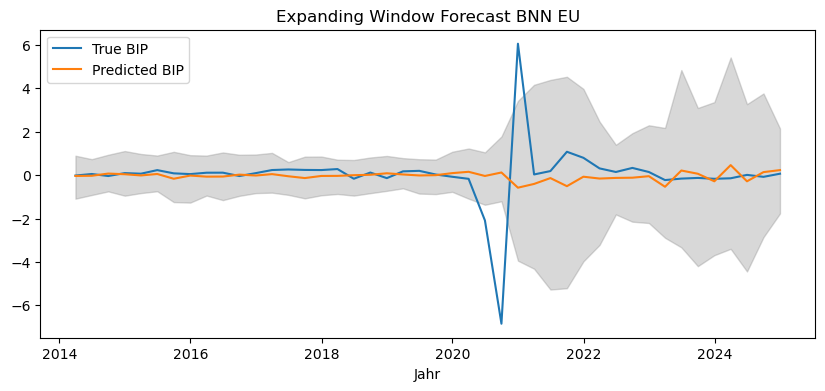

RMSE: 1.528


In [312]:
# Auswertung
dates = data.index[-len(y_trues):]  # Get the corresponding dates for the predictions
plt.figure(figsize=(10, 4))
plt.plot(dates, y_trues, label='True BIP')
plt.plot(dates, y_preds_mean, label='Predicted BIP')
plt.xlabel("Jahr")
plt.legend()
# Konfidenzintervale als graue Schattierung hinzufügen
plt.fill_between(dates, y_preds_upper, y_preds_lower, color='gray', alpha=0.3, label='Konfidenzintervall')
plt.title("Expanding Window Forecast BNN EU")
#plt.savefig("./plots/final_forecast_VAR_CI.png")
plt.show()

print(f"RMSE: {rmse:.3f}")

Deutschland 

In [313]:
data = df_q_DE[cols_to_standardize].dropna()

In [314]:
rmse, y_preds_mean, y_preds_lower, y_preds_upper, y_trues = evaluate_BNN_pretrained(data.values, bnn_us, initial_window=54, n_samples=100, learning_rate=1e-2)
print(rmse)

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variabl

1.5832153197360563


In [315]:
print(f"RMSE: {rmse:.3f}")
results_df = pd.DataFrame({
    "date": data.index[-len(y_trues):],
    "true": y_trues,
    "pred_mean": y_preds_mean,
    "CI_lower": y_preds_lower,
    "CI_upper": y_preds_upper,
})
results_df.to_csv("./Data/results/BNN_DE_results_Pre.csv", index=False)

RMSE: 1.583


Frankreich

In [316]:
data = df_q_FR[cols_to_standardize].dropna()

In [317]:
rmse, y_preds_mean, y_preds_lower, y_preds_upper, y_trues = evaluate_BNN_pretrained(data.values, bnn_us, initial_window=54, n_samples=100, learning_rate=1e-2)
print(rmse)

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variabl

1.639517921074791


In [318]:
print(f"RMSE: {rmse:.3f}")
results_df = pd.DataFrame({
    "date": data.index[-len(y_trues):],
    "true": y_trues,
    "pred_mean": y_preds_mean,
    "CI_lower": y_preds_lower,
    "CI_upper": y_preds_upper,
})
results_df.to_csv("./Data/results/BNN_FR_results_Pre.csv", index=False)

RMSE: 1.640


Italien

In [319]:
data = df_q_IT[cols_to_standardize].dropna()

In [320]:
rmse, y_preds_mean, y_preds_lower, y_preds_upper, y_trues = evaluate_BNN_pretrained(data.values, bnn_us, initial_window=54, n_samples=100, learning_rate=1e-2)
print(rmse)

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variabl

1.7317944081503567


In [321]:
print(f"RMSE: {rmse:.3f}")
results_df = pd.DataFrame({
    "date": data.index[-len(y_trues):],
    "true": y_trues,
    "pred_mean": y_preds_mean,
    "CI_lower": y_preds_lower,
    "CI_upper": y_preds_upper,
})
results_df.to_csv("./Data/results/BNN_IT_results_Pre.csv", index=False)

RMSE: 1.732


### Auswertung mit Gradient Boosting

In [177]:
def evaluate_GB_forecaster(data, initial_window=54, window_length =5, n_estimators=200, learning_rate = 0.1, max_depth= 4, subsample =0.8):
    # Ziel und Prädiktoren trennen
    y_all = data["GDP"]
    X_all = data.drop(columns=["GDP"])
    # Expanding Window Splitter definieren
    splitter = ExpandingWindowSplitter(
        initial_window=initial_window, # Erstes Trainingsfenster
        fh=1,   # Forecast horizon (1 Zeitschritt in die Zukunft)
        step_length=1 # Schrittweite für das Fenster
    )

    # Regressionsmodell einbinden (Gradient Boosting mit Lag-Features)
    forecaster = make_reduction(
        GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, subsample=subsample),
        strategy="direct",
        window_length=window_length,
        scitype="tabular-regressor"
    )

    y_preds = []
    y_trues = []


    for train_idx, test_idx in splitter.split(y_all):
        y_train = y_all.iloc[train_idx]
        X_train = X_all.iloc[train_idx]
        y_test = y_all.iloc[test_idx]
        X_test = X_all.iloc[test_idx]

        fh_relative = ForecastingHorizon(test_idx - train_idx[-1], is_relative=True)

        forecaster.fit(y_train, X=X_train, fh=1)
        y_pred = forecaster.predict(fh=fh_relative, X=X_test)

        y_preds.extend(y_pred.values)
        y_trues.extend(y_test.values)


    rmse = np.sqrt(mean_squared_error(y_trues, y_preds))
    return rmse, y_preds, y_trues
    


In [178]:
results = pd.read_csv("./Data/results_GB.csv")
best_params  = results.loc[results['rmse'].idxmin()]
print(f"Best parameter combination: window_length={best_params[0]}, n_estimators={best_params[1]}, learning_rate={best_params[2]}, subsample = {best_params[3]}, max_depth = {best_params[3]}, RMSE={best_params[4]:.4f}")

Best parameter combination: window_length=3.0, n_estimators=100.0, learning_rate=0.01, subsample = 3.0, max_depth = 3.0, RMSE=1.0000


/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_41382/1039090733.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Best parameter combination: window_length={best_params[0]}, n_estimators={best_params[1]}, learning_rate={best_params[2]}, subsample = {best_params[3]}, max_depth = {best_params[3]}, RMSE={best_params[4]:.4f}")


Für die ganze EU

In [179]:
data = df_q_EU[cols_to_standardize].dropna()
data.index.freq = pd.infer_freq(data.index)

rmse, y_preds, y_trues  = evaluate_GB_forecaster(
        data,
        initial_window = 54,  ## need to be 150 
        window_length = int(best_params[0]), 
        n_estimators = int(best_params[1]), 
        learning_rate = float(best_params[2]), 
        max_depth = int(best_params[3]), 
        subsample = float(best_params[4]))

print(f"RMSE (for the test set): {rmse:.4f}")

/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_41382/3787626134.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  window_length = int(best_params[0]),
/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_41382/3787626134.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  n_estimators = int(best_params[1]),
/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_41382/3787626134.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, u

RMSE (for the test set): 1.6047


Für Deutschland

In [180]:
data = df_q_DE[cols_to_standardize].dropna()
data.index.freq = pd.infer_freq(data.index)

rmse, y_preds, y_trues  = evaluate_GB_forecaster(
        data,
        initial_window = 54,  ## need to be 150 
        window_length = int(best_params[0]), 
        n_estimators = int(best_params[1]), 
        learning_rate = float(best_params[2]), 
        max_depth = int(best_params[3]), 
        subsample = float(best_params[4]))

print(f"RMSE (for the test set): {rmse:.4f}")

/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_41382/1402251547.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  window_length = int(best_params[0]),
/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_41382/1402251547.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  n_estimators = int(best_params[1]),
/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_41382/1402251547.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, u

RMSE (for the test set): 1.5055


Für Frankreich

In [181]:
data = df_q_FR[cols_to_standardize].dropna()
data.index.freq = pd.infer_freq(data.index)

rmse, y_preds, y_trues  = evaluate_GB_forecaster(
        data,
        initial_window = 54,  ## need to be 150 
        window_length = int(best_params[0]), 
        n_estimators = int(best_params[1]), 
        learning_rate = float(best_params[2]), 
        max_depth = int(best_params[3]), 
        subsample = float(best_params[4]))

print(f"RMSE (for the test set): {rmse:.4f}")

/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_41382/4255477406.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  window_length = int(best_params[0]),
/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_41382/4255477406.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  n_estimators = int(best_params[1]),
/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_41382/4255477406.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, u

RMSE (for the test set): 1.6742


Für Italien

In [182]:
data = df_q_IT[cols_to_standardize].dropna()
data.index.freq = pd.infer_freq(data.index)

rmse, y_preds, y_trues  = evaluate_GB_forecaster(
        data,
        initial_window = 54,  ## need to be 150 
        window_length = int(best_params[0]), 
        n_estimators = int(best_params[1]), 
        learning_rate = float(best_params[2]), 
        max_depth = int(best_params[3]), 
        subsample = float(best_params[4]))

print(f"RMSE (for the test set): {rmse:.4f}")

/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_41382/119437263.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  window_length = int(best_params[0]),
/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_41382/119437263.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  n_estimators = int(best_params[1]),
/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_41382/119437263.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use 

RMSE (for the test set): 1.6392


### Für Random Forest

In [ ]:
def evaluate_RF_forecaster(y_all, X_all, n_estimators=100, window_length=2, initial_window= 54):
    # Expanding Window Splitter definieren
    splitter = ExpandingWindowSplitter(
        initial_window=initial_window, # Erstes Trainingsfenster
        fh=1,   # Forecast horizon (1 Zeitschritt in die Zukunft)
        step_length=1 # Schrittweite für das Fenster
    )

    # Regressionsmodell einbinden (Random Forest mit Lag-Features)
    forecaster = make_reduction(
        RandomForestRegressor(n_estimators=n_estimators, max_depth=None, random_state=42),
        strategy="direct",
        window_length=window_length,
        scitype="tabular-regressor"
    )

    # Forecasting Loop
    y_preds = []
    y_trues = []


    for train_idx, test_idx in splitter.split(y_all):
        y_train = y_all.iloc[train_idx]
        X_train = X_all.iloc[train_idx]
        y_test = y_all.iloc[test_idx]
        X_test = X_all.iloc[test_idx]

        fh_relative = ForecastingHorizon(test_idx - train_idx[-1], is_relative=True)

        forecaster.fit(y_train, X=X_train, fh=1)
        y_pred = forecaster.predict(fh=fh_relative, X=X_test)

        y_preds.extend(y_pred.values)
        y_trues.extend(y_test.values)
    # RMSE berechnen
    rmse = np.sqrt(mean_squared_error(y_trues, y_preds))
    return rmse, y_preds, y_trues



In [328]:
results = pd.read_csv("./Data/results_RF.csv")
best_params  = results.loc[results['rmse'].idxmin()]
print(f"Best parameter combination:  window_length={best_params[0]}, n_estimators={best_params[1]}, RMSE: {best_params[2]:.3f}")


Best parameter combination:  window_length=3.0, n_estimators=200.0, RMSE: 0.459


/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_41382/2249902491.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Best parameter combination:  window_length={best_params[0]}, n_estimators={best_params[1]}, RMSE: {best_params[2]:.3f}")


In [329]:
data = df_q_EU[cols_to_standardize].dropna()
# Ziel und Prädiktoren trennen
y_all = data["GDP"]
X_all = data.drop(columns=["GDP"])

In [330]:
rmse, y_preds, y_trues = evaluate_RF_forecaster(
        y_all = y_all, 
        X_all = X_all, 
        initial_window = 54,  
        window_length = int(best_params[0]), 
        n_estimators =  int(best_params[1]))

# Calculate RMSE using only data from index 151 onward
print(f"RMSE (for the test set): {rmse:.4f}")

/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_41382/1570748545.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  window_length = int(best_params[0]),
/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_41382/1570748545.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  n_estimators =  int(best_params[1]))


RMSE (for the test set): 1.6220


Deutschland

In [331]:
data = df_q_DE[cols_to_standardize].dropna()
# Ziel und Prädiktoren trennen
y_all = data["GDP"]
X_all = data.drop(columns=["GDP"])

In [332]:
rmse, y_preds, y_trues = evaluate_RF_forecaster(
        y_all = y_all, 
        X_all = X_all, 
        initial_window = 54,  
        window_length = int(best_params[0]), 
        n_estimators =  int(best_params[1]))

# Calculate RMSE using only data from index 151 onward
print(f"RMSE (for the test set): {rmse:.4f}")

/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_41382/1570748545.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  window_length = int(best_params[0]),
/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_41382/1570748545.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  n_estimators =  int(best_params[1]))


RMSE (for the test set): 1.5100


Frankreich

In [334]:
data = df_q_FR[cols_to_standardize].dropna()
# Ziel und Prädiktoren trennen
y_all = data["GDP"]
X_all = data.drop(columns=["GDP"])

In [335]:
rmse, y_preds, y_trues = evaluate_RF_forecaster(
        y_all = y_all, 
        X_all = X_all, 
        initial_window = 54,  
        window_length = int(best_params[0]), 
        n_estimators =  int(best_params[1]))

# Calculate RMSE using only data from index 151 onward
print(f"RMSE (for the test set): {rmse:.4f}")

/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_41382/1570748545.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  window_length = int(best_params[0]),
/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_41382/1570748545.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  n_estimators =  int(best_params[1]))


RMSE (for the test set): 1.6341


Italien

In [336]:
data = df_q_IT[cols_to_standardize].dropna()
# Ziel und Prädiktoren trennen
y_all = data["GDP"]
X_all = data.drop(columns=["GDP"])

In [337]:
rmse, y_preds, y_trues = evaluate_RF_forecaster(
        y_all = y_all, 
        X_all = X_all, 
        initial_window = 54,  
        window_length = int(best_params[0]), 
        n_estimators =  int(best_params[1]))

# Calculate RMSE using only data from index 151 onward
print(f"RMSE (for the test set): {rmse:.4f}")

/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_41382/1570748545.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  window_length = int(best_params[0]),
/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_41382/1570748545.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  n_estimators =  int(best_params[1]))


RMSE (for the test set): 1.5975


### Für LSTM

In [ ]:
def evaluate_LSTM_forecaster(data_scaled, window_length=5, hidden_layer_sizes=32, initial_window=54):

    n_total = len(data_scaled)

    y_preds = []
    y_trues = []

    for i in range(initial_window, n_total - 1):
        # Take data up to time i
        train_data = data_scaled[:i]

        # Create sequences
        X_train, y_train = [], []
        for j in range(window_length, len(train_data)):
            X_train.append(train_data[j - window_length:j])
            y_train.append(train_data[j, 0])  # Zielvariable (GDPC1) 

        X_train = np.array(X_train)
        y_train = np.array(y_train)

        # Define LSTM model
        model = Sequential()
        model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
        model.add(LSTM(hidden_layer_sizes))
        model.add(Dense(1))
        model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

        # Train model
        model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=0)

        # Predict next time step (i)
        x_input = data_scaled[i - window_length:i].reshape(1, window_length, data_scaled.shape[1])
        y_pred_scaled = model.predict(x_input, verbose=0)[0, 0]

        y_preds.append(y_pred_scaled)

        # True Value
        y_true_transformed = data_scaled[i, 0]  # GDPC1
        y_trues.append(y_true_transformed)
    rmse = np.sqrt(mean_squared_error(y_trues, y_preds))
    return rmse, y_preds, y_trues

EU

In [340]:
data = df_q_EU[cols_to_standardize].dropna()
rmse, y_preds, y_trues = evaluate_LSTM_forecaster(np.array(data), initial_window=54)    
print(f"RMSE: {rmse:.4f}")

RMSE: 2.0541


Deutschland

In [341]:
data = df_q_DE[cols_to_standardize].dropna()
rmse, y_preds, y_trues = evaluate_LSTM_forecaster(np.array(data), initial_window=54)    
print(f"RMSE: {rmse:.4f}")

RMSE: 1.5809


Frankreich

In [342]:
data = df_q_FR[cols_to_standardize].dropna()
rmse, y_preds, y_trues = evaluate_LSTM_forecaster(np.array(data), initial_window=54)    
print(f"RMSE: {rmse:.4f}")   

RMSE: 2.0722


Italien

In [343]:
data = df_q_IT[cols_to_standardize].dropna()
rmse, y_preds, y_trues = evaluate_LSTM_forecaster(np.array(data), initial_window=54)    
print(f"RMSE: {rmse:.4f}")

RMSE: 2.0534


### Baseline 

In [367]:
def baseline_forecast(series,  initial_window=54):
    """
    Naiver Forecast: prognostiziert y_{t+1} = y_t
    Gibt Vorhersagen, wahre Werte und RMSE zurück.
    """
    y_true = series[initial_window:]            # y_{t+1}
    y_pred = series[initial_window-1:-1]           # y_t als Prognose für y_{t+1}

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse, y_pred, y_true


In [368]:
data = df_q_EU[cols_to_standardize].dropna()
rmse, y_preds, y_trues = baseline_forecast(np.array(data.GDP), initial_window=54)
print(f"RMSE: {rmse:.4f}")

RMSE: 2.2670


In [369]:
data = df_q_DE[cols_to_standardize].dropna()
rmse, y_preds, y_trues = baseline_forecast(np.array(data.GDP), initial_window=54)
print(f"RMSE: {rmse:.4f}")

RMSE: 2.0837


In [370]:
data = df_q_FR[cols_to_standardize].dropna()
rmse, y_preds, y_trues = baseline_forecast(np.array(data.GDP), initial_window=54)
print(f"RMSE: {rmse:.4f}")

RMSE: 2.3154


In [371]:
data = df_q_IT[cols_to_standardize].dropna()
rmse, y_preds, y_trues = baseline_forecast(np.array(data.GDP), initial_window=54)
print(f"RMSE: {rmse:.4f}")

RMSE: 2.2107
